# Test Tensorflow-federated (TFF) library

## Test #1 : MNIST classification

In [ ]:
import os
import collections
import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

tf.config.set_visible_devices([tf.config.list_physical_devices('GPU')[0]], 'GPU')

nest_asyncio.apply()

print('Tensorflow version : {}'.format(tf.__version__))
print('Tensorflow-federated version : {}'.format(tff.__version__))
print('# GPUs : {}'.format(len(tf.config.list_logical_devices('GPU'))))

tff.federated_computation(lambda: 'Hello, World!')()

2022-11-23 10:52:23.173570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 10:52:23.271247: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-23 10:52:23.295402: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/etinfo/users2/qlanglois/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is requir

Tensorflow version : 2.10.0
Tensorflow-federated version : 0.39.0
# GPUs : 1


2022-11-23 10:52:34.342405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 10:52:34.721610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14783 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


b'Hello, World!'

In [ ]:
emnist_train, emnist_valid = tff.simulation.datasets.emnist.load_data()
print('Dataset length :\n  Train length : {}\n  Valid length : {}'.format(
    len(emnist_train.client_ids), len(emnist_valid.client_ids)
))
print('Data signature : {}'.format(emnist_train.element_type_structure))

Dataset length :
  Train length : 3383
  Valid length : 3383
Data signature : OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)), ('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])


## Dataset analysis

In [13]:
train_ids = emnist_train.client_ids
valid_ids = emnist_valid.client_ids

print('# Ids :\n  Train : {}\n  Valid : {}\n  Train in valid : {}\n  Valid in train : {}'.format(
    len(train_ids), len(valid_ids),
    len([t_id for t_id in train_ids if t_id in valid_ids]),
    len([v_id for v_id in valid_ids if v_id in train_ids])
))

# Ids :
  Train : 3383
  Valid : 3383
  Train in valid : 3383
  Valid in train : 3383


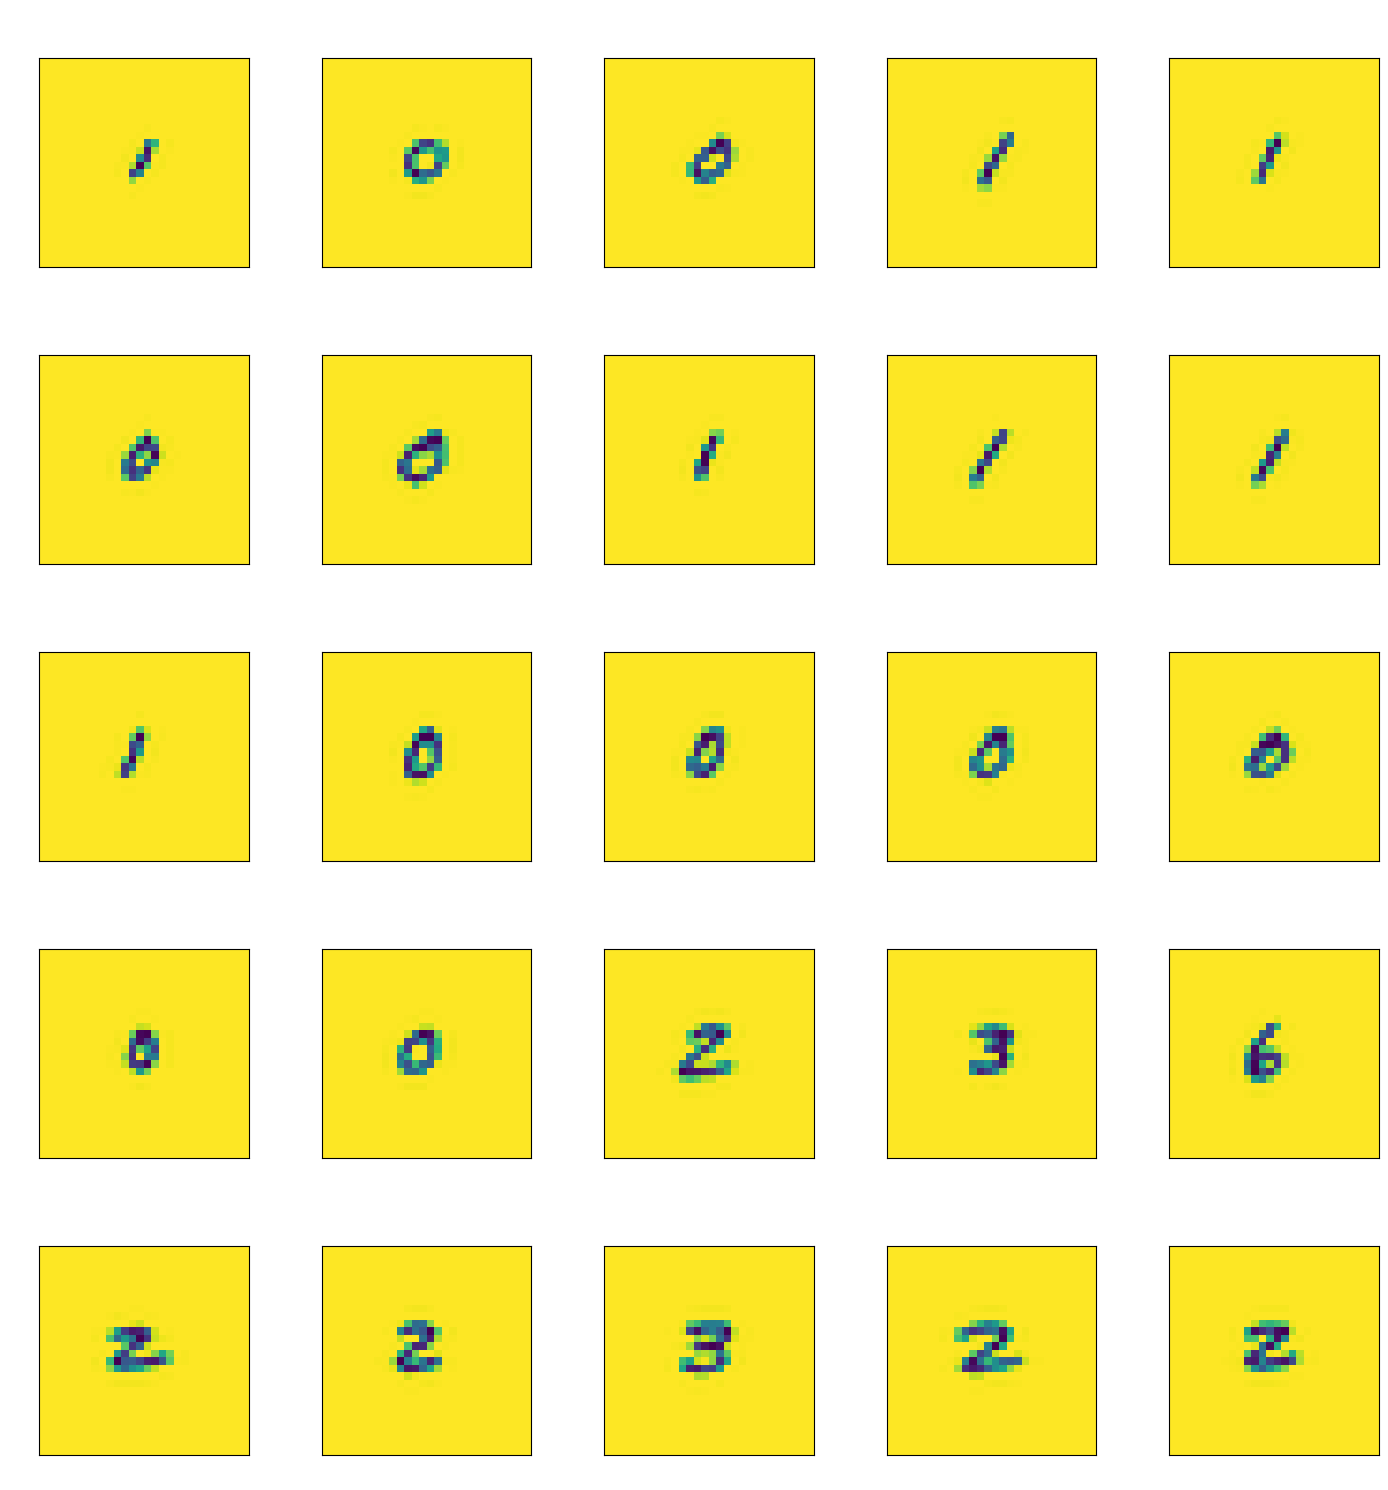

In [4]:
from utils import plot_multiple

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0]
)

datas = {'Data #{}\nLabel : {}'.format(i, data['label']) : data['pixels'] for i, data in enumerate(example_dataset.take(25))}
plot_multiple(
    ** datas, plot_type = 'imshow', ncols = 5
)

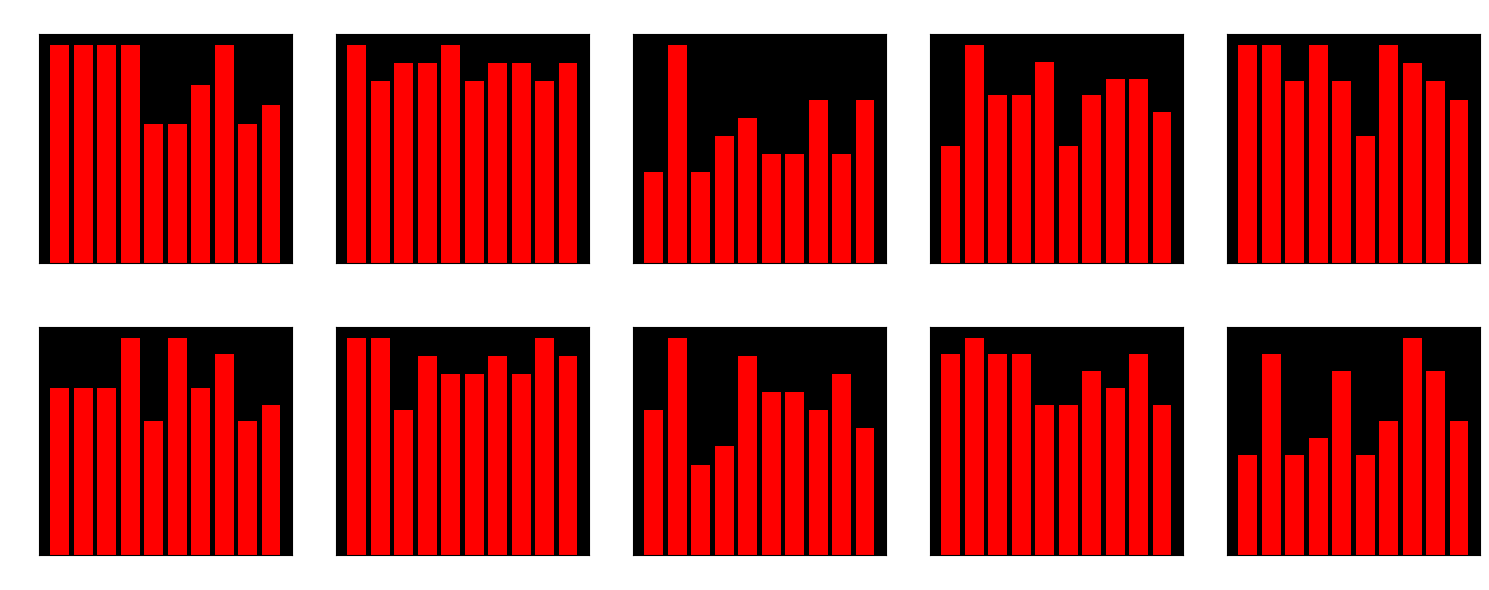

In [5]:
plot_data = {}
for i in range(10):
    counts = {}
    for data in emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[i]):
        label = data['label'].numpy()
        counts.setdefault(label, []).append(label)
    plot_data['Client {}'.format(i)] = {'y' : [len(v) for v in counts.values()], 'x' : list(counts.keys())}

plot_multiple(** plot_data, plot_type = 'bar', use_subplots = True, ncols = 5)

## Initialization

In [ ]:
def preprocess(dataset, epochs = 50, batch_size = 32, shuffle_size = 1024, prefetch_size = 16):
    def batch_format_fn(data):
        return collections.OrderedDict(
            x = tf.reshape(data['pixels'], [-1, 28 * 28]),
            y = tf.reshape(data['label'], [-1, 1])
        )
    
    return dataset.repeat(epochs).shuffle(shuffle_size, seed = 1).batch(batch_size).map(batch_format_fn).prefetch(prefetch_size)

def make_federated_data(client_data, ids = None, n = None):
    if ids is None: ids = client_data.client_ids[:n]
    return [
        preprocess(client_data.create_tf_dataset_for_client(x)) for x in ids
    ]

train_fed_data = make_federated_data(emnist_train, n = 25)
valid_fed_data = make_federated_data(emnist_valid, n = 10)

print('# datasets : train {} - valid {}'.format(len(train_fed_data), len(valid_fed_data)))

# datasets : train 25 - valid 10


In [10]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ], name = 'simple_mlp')
    model.build((None, 28 * 28))
    return model

def build_fed_model():
    model = build_model()
    return tff.learning.from_keras_model(
        model,
        input_spec = train_fed_data[0].element_spec,
        loss       = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics    = [tf.keras.metrics.SparseCategoricalAccuracy()]
    )

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    build_fed_model,
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = 0.02),
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = 0.5)
)

print(iterative_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[784,32],
      float32[32],
      float32[32,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64
  >
>@SERVER)


## Training

In [ ]:
state = iterative_process.initialize()

In [11]:
result = iterative_process.next(state, train_fed_data)
state, metrics = result.state, result.metrics
print('Round 1, metrics : {}'.format(metrics))

Round 1, metrics : OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.11121808), ('loss', 10.880158), ('num_examples', 119450), ('num_batches', 3744)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


In [12]:
epochs = 10
for epoch in range(2, epochs + 1):
    result = iterative_process.next(state, train_fed_data)
    state, metrics = result.state, result.metrics
    print('Epoch {} : {}'.format(epoch, metrics['client_work']['train']))


Epoch 2 : OrderedDict([('sparse_categorical_accuracy', 0.11239012), ('loss', 8.414583), ('num_examples', 119450), ('num_batches', 3744)])
Epoch 3 : OrderedDict([('sparse_categorical_accuracy', 0.11590624), ('loss', 4.1076326), ('num_examples', 119450), ('num_batches', 3744)])
Epoch 4 : OrderedDict([('sparse_categorical_accuracy', 0.11741314), ('loss', 3.1399808), ('num_examples', 119450), ('num_batches', 3744)])
Epoch 5 : OrderedDict([('sparse_categorical_accuracy', 0.119054), ('loss', 2.7143598), ('num_examples', 119450), ('num_batches', 3744)])
Epoch 6 : OrderedDict([('sparse_categorical_accuracy', 0.120912515), ('loss', 2.2914877), ('num_examples', 119450), ('num_batches', 3744)])
Epoch 7 : OrderedDict([('sparse_categorical_accuracy', 0.12070322), ('loss', 2.2914622), ('num_examples', 119450), ('num_batches', 3744)])
Epoch 8 : OrderedDict([('sparse_categorical_accuracy', 0.12071997), ('loss', 2.2932537), ('num_examples', 119450), ('num_batches', 3744)])
Epoch 9 : OrderedDict([('spar